# Inversion of gravimetric data

Inversion aims to find a subsurface model, which describes the observed field measurements within their error bounds. Similar to medical imaging, geophysical imaging has revolutionalized the discipline. During inversion, we iteratively update the model parameters to match the measured data as best as possible. How this model update is calculated, and where the pitfalls are, will be discussed detail in Geophysics II in the upcoming wintersemester. Here, we will approach the subject in a practical manner using ready-made optimization routines. You can read about optimization in Python here: https://scipy-lectures.org/intro/scipy.html#optimization-and-fit-scipy-optimize

In [8]:
# Standard
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")

# We will be using pyGIMLi (www.pygimli.org) and a few customized functions
import pygimli as pg
from pygimli.meshtools import createPolygon

## Loading and visualizing the data

In [116]:
data = pd.read_csv("example_data/gravimetric_synthetic_data.csv")
#data = pd.read_csv("example_data/gravity_profile_duerwiss.csv"); data["x (m)"] -= data["x (m)"].min()
data.head()

x (m)  g_z (mGal)
0    0.0    0.061984
1    2.0    0.065566
2    4.0    0.066142
3    6.0   -0.009367
4    8.0    0.155412

<AxesSubplot:xlabel='x (m)'>

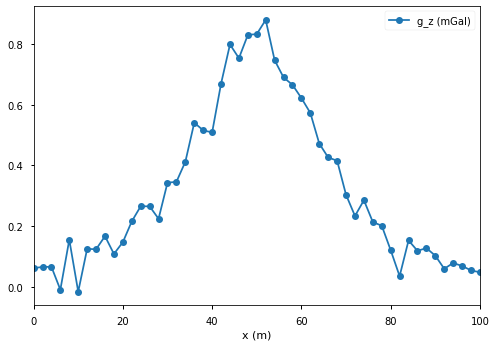

In [117]:
data.set_index("x (m)").plot(marker="o")

## Fitting a horizontal cylinder automatically

We will use the analytical function from the modeling notebook as our forward response.

In [118]:
def grav_cylinder(x, r, h, dRho):
    """Gravitational anomaly of a horizontal cylinder.
    x = Position (m)
    r = Radius (m)
    h = height (m)"""
    G = 6.6743e-11
    gz = 2 * np.pi * r**2 * dRho * G * h / (x**2 + h**2)
    gz *= 1e5 # unit conversion
    return gz

In [119]:
xobs = data["x (m)"]
gz = data["g_z (mGal)"]

We can use [least-squares function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) to give us the best fit. We have to define a target function that we want to minimize in a least-squares sense. This function returns the difference between simulated and observed data from the field. Additionally, we have to define starting values and bounds for the parameter search. Note that the final model might be dependent on both starting model and bounds.

In [123]:
# starting values: x-postion, radius, depth (density remains fixed here for now)
p0 = 10, 5, 20
dRho = 5000

def target(parameters):
    xpos, r, h = parameters
    simulated = grav_cylinder(xobs - xpos, r, h, dRho)
    return gz - simulated

from scipy.optimize import least_squares
result = least_squares(target, p0, bounds=([xobs.min(), 1, 1], [xobs.max(), 100., 100]))

### Visualize inversion result

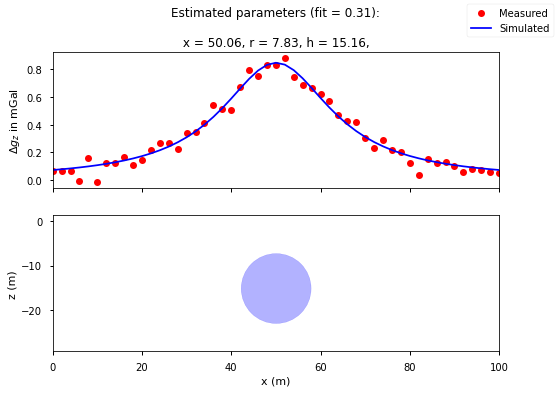

In [124]:
def plot_result(xpos, r, h):
    dg = grav_cylinder(xobs - xpos, r, h, dRho)
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
    ax1.plot(xobs, gz, "ro", label="Measured")
    ax2.set_xlabel("x (m)")
    ax2.set_ylabel("z (m)")
    ax1.set_ylabel("$\Delta g_z$ in mGal")
    line, = ax1.plot(xobs, dg, "b-", label="Simulated")
    circle = plt.Circle((xpos, -h), r, alpha=0.3, color=line.get_color())
    ax2.add_artist(circle)
    ax2.set_ylim(-h - r - 5, 0)
    ax2.set_xlim(xobs.min(), xobs.max())
    ax2.set_aspect("equal")
    for ax in ax1, ax2:
        ax.set(adjustable='datalim')
    
    # Calculating the fit
    fit = np.linalg.norm(dg - gz)
    fitstr = "fit = %.2f" % fit

    ax1.set_title("Estimated parameters (%s)" % fitstr + ":\n\n x = %.2f, r = %.2f, h = %.2f, " % tuple(result.x) )
    fig.legend()

plot_result(*result.x)

## Fitting an n-sided polygon

In [125]:
density = 5000

def poly(points, dRho):
    p = points.reshape(len(points)//2,2)
    circ = createPolygon(p, isClosed=True)#, interpolate="spline", addNodes=10)
    gz_p = solveGravimetry(circ, -dRho, xobs)
    return circ, gz_p

def target(points):
    _, gz_p = poly(points, density)
    return gz_p - gz

p = np.array([[20,-20],[20,-10],[60,-10], [80,-25]])

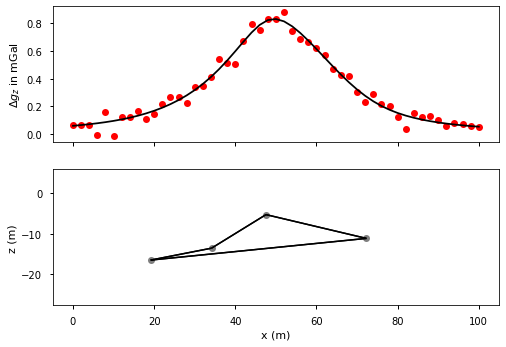

In [126]:
from modinv import fitlimits, solveGravimetry
ul, uu = fitlimits(p[:,0], p[:,1])
p0 = p.flatten()
result_pol = least_squares(target, p0, bounds=(ul, uu))
p = result_pol.x.reshape(p.shape)

final, response = poly(result_pol.x, dRho)

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(xobs, gz, "ro")
ax2.set_xlabel("x (m)")
ax2.set_ylabel("z (m)")
ax1.set_ylabel("$\Delta g_z$ in mGal")
line, = ax1.plot(xobs, response, "k-")
pg.show(final, ax=ax2, fillRegion=False, showNodes=True)
for ax in ax1, ax2:
    ax.set(adjustable='datalim')